# Credit Score prediction

In [1]:
#Install dependencies
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split #Split data for training and testing
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

### Data exploration

In [2]:
df = pd.read_csv('Data/loan_data.csv')
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [3]:
num_rows = df.shape[0]
print(f"Number of rows in df: {num_rows}")

Number of rows in df: 45000


In [4]:
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


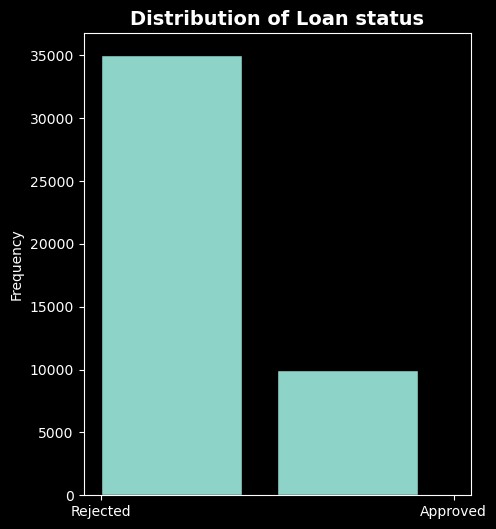

In [5]:
with plt.style.context("dark_background"):
    plt.figure(figsize=(5, 6))
    plt.hist(df['loan_status'], bins=2, edgecolor='black', width=0.4, align='mid')
    plt.title('Distribution of Loan status', fontsize=14, fontweight='bold')
    plt.xticks([0, 1], ['Rejected', 'Approved'])
    plt.ylabel('Frequency')
    plt.savefig('./Pictures/loanstatus_distribution.png')
    plt.show()
    plt.close()
    

In [6]:
#Finding the unique values for each categorical column for label encoding
print("Values for 'person_education':",df['person_education'].unique())
print("Values for 'person_home_ownership':",df['person_home_ownership'].unique())
print("Values for 'previous_loan_defaults_on_file':",df['previous_loan_defaults_on_file'].unique())

Values for 'person_education': ['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']
Values for 'person_home_ownership': ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
Values for 'previous_loan_defaults_on_file': ['No' 'Yes']


### Label Encoding

In [7]:
education_mapping = {'High School': 0, 'Associate': 1, 'Bachelor': 2, 'Master': 3, 'Doctorate': 4}
df['person_education'] = df['person_education'].map(education_mapping)
print("Mapping for 'person_education':", education_mapping)

home_ownership_mapping = {'OTHER':3,'RENT':1,'MORTGAGE':2,'OWN':3}
df['person_home_ownership'] = df['person_home_ownership'].map(home_ownership_mapping)
print('Mapping for "person_home_ownership":', home_ownership_mapping)

loan_mapping = {'No':0,'Yes':1}
df['previous_loan_defaults_on_file'] = df['previous_loan_defaults_on_file'].map(loan_mapping)
print('Mapping for "previous_loan_defaults_on_file":', loan_mapping)

Mapping for 'person_education': {'High School': 0, 'Associate': 1, 'Bachelor': 2, 'Master': 3, 'Doctorate': 4}
Mapping for "person_home_ownership": {'OTHER': 3, 'RENT': 1, 'MORTGAGE': 2, 'OWN': 3}
Mapping for "previous_loan_defaults_on_file": {'No': 0, 'Yes': 1}


In [8]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,3,71948.0,0,1,35000.0,PERSONAL,16.02,0.49,3.0,561,0,1
1,21.0,female,0,12282.0,0,3,1000.0,EDUCATION,11.14,0.08,2.0,504,1,0
2,25.0,female,0,12438.0,3,2,5500.0,MEDICAL,12.87,0.44,3.0,635,0,1
3,23.0,female,2,79753.0,0,1,35000.0,MEDICAL,15.23,0.44,2.0,675,0,1
4,24.0,male,3,66135.0,1,1,35000.0,MEDICAL,14.27,0.53,4.0,586,0,1


### Decision Tree Model

In [9]:
# features = ["person_age", "person_income", "person_emp_exp", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", "credit_score"]
features = ["person_income","loan_amnt","person_emp_exp", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", "credit_score"]
X = df[features]
y = df.loan_status

In [10]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
creditModel = DecisionTreeRegressor()
creditModel.set_params(min_samples_split=200)
creditModel.fit(train_X, train_y)

DecisionTreeRegressor(min_samples_split=200)

In [11]:
# Recursive Feature Elimination with Cross-Validation
rfe = RFE(estimator=creditModel, n_features_to_select=1)
rfe.fit(X, y)

# Ranking of features
ranking = rfe.ranking_
features = X.columns

# Print feature rankings
feature_ranking = sorted(zip(ranking, features))
print("Feature ranking:")
for rank, feature in feature_ranking:
    print(f"{feature}: {rank}")

Feature ranking:
loan_percent_income: 1
loan_int_rate: 2
person_income: 3
loan_amnt: 4
credit_score: 5
cb_person_cred_hist_length: 6
person_emp_exp: 7


In [12]:
# get predicted prices on validation data
val_predictions = creditModel.predict(val_X)
accuracy = accuracy_score(val_y, val_predictions.round())
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 85.47%


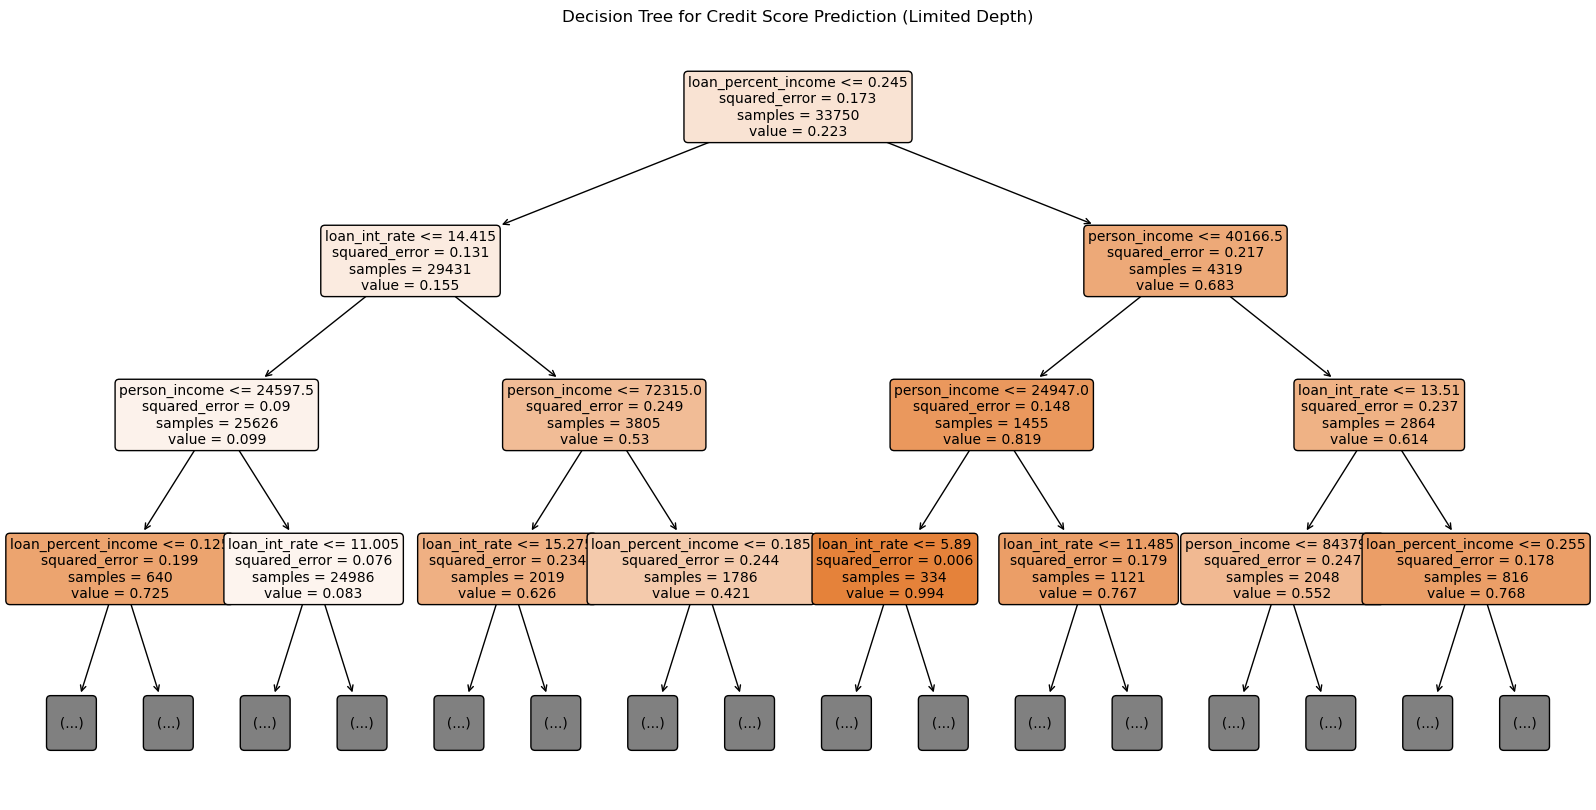

In [13]:
plt.figure(figsize=(20, 10))
tree.plot_tree(creditModel, feature_names=features, filled=True, rounded=True, fontsize=10, max_depth=3)
plt.title('Decision Tree for Credit Score Prediction (Limited Depth)')
plt.savefig('./Pictures/decisionTree')
plt.show()

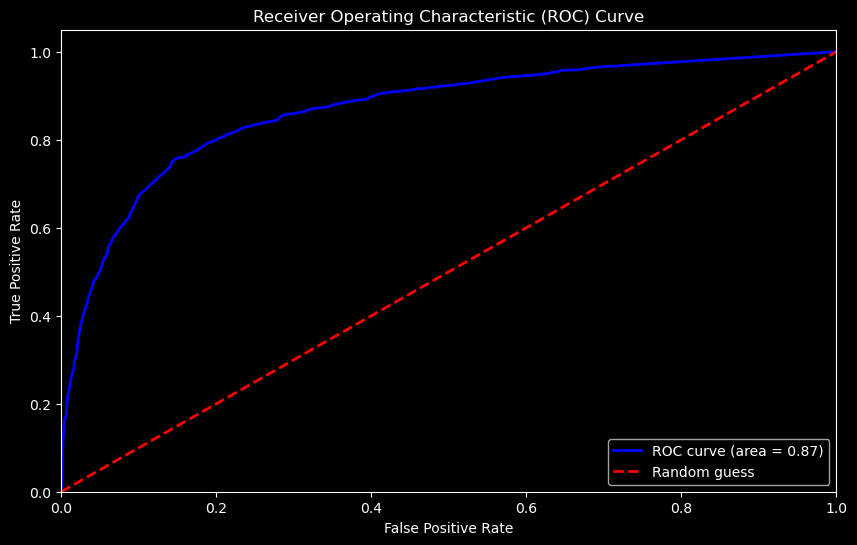

In [14]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(val_y, val_predictions)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(val_y, val_predictions)

with plt.style.context("dark_background"):
    # Plot the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig('./Pictures/rocCurve')
    plt.show()

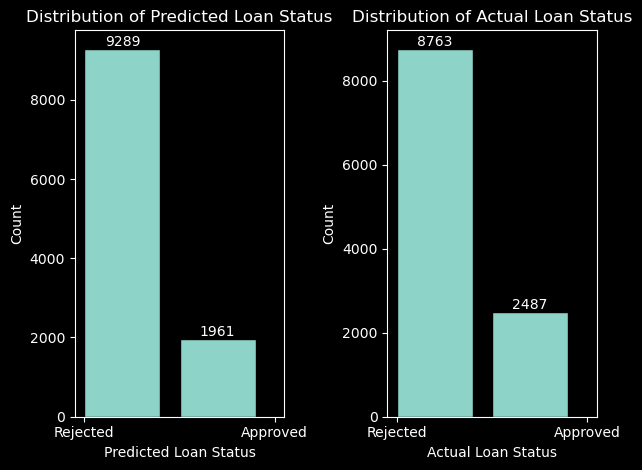

In [15]:

with plt.style.context("dark_background"):
    # Plot the distribution of predicted loan status
    plt.subplot(1, 2, 1)
    plt.title('Distribution of Predicted Loan Status')
    n, bins, patches = plt.hist(val_predictions, bins=2, edgecolor='black', width=0.4, align='mid')
    plt.xticks([0, 1], ['Rejected', 'Approved'])
    plt.xlabel('Predicted Loan Status')
    plt.ylabel('Count')
    for i in range(len(n)):
        plt.text(bins[i] + 0.2, n[i], str(int(n[i])), ha='center', va='bottom')

    # Plot the distribution of actual loan status
    plt.subplot(1, 2, 2)
    plt.title('Distribution of Actual Loan Status')
    n, bins, patches = plt.hist(val_y, bins=2, edgecolor='black', width=0.4, align='mid')
    plt.xticks([0, 1], ['Rejected', 'Approved'])
    plt.xlabel('Actual Loan Status')
    plt.ylabel('Count')
    for i in range(len(n)):
        plt.text(bins[i] + 0.2, n[i], str(int(n[i])), ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('./Pictures/predictionDistribution')
    plt.show()

In [16]:
# Get the confusion matrix
cm = confusion_matrix(val_y, val_predictions.round())

# Extract the true positives, true negatives, false positives, and false negatives
tn, fp, fn, tp = cm.ravel()

print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

True Positives: 1386
True Negatives: 8229
False Positives: 534
False Negatives: 1101


In [17]:
print(f"Precision: Acuracy of positive predictions: {tp/(tp+fp)}")

Precision: Acuracy of positive predictions: 0.721875


In [18]:
val_X.head()
val_X['Actual'] = val_y.values
val_X['Predicted'] = val_predictions.round().astype(int)
val_X.head()

,person_income,loan_amnt,person_emp_exp,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,Actual,Predicted
44885,72707.0,24000.0,4,10.84,0.33,4.0,614,1,1
10988,85497.0,14075.0,0,14.74,0.16,4.0,623,0,0
26912,144175.0,8800.0,5,11.01,0.06,7.0,663,0,0
7473,64677.0,10750.0,4,11.14,0.17,2.0,567,0,0
32767,61232.0,8000.0,0,7.49,0.13,4.0,608,0,0


In [19]:
# Define the input data
input_data = pd.DataFrame({
    'person_income': [72707.0],
    'loan_amnt': [24000.0],
    'person_emp_exp': [4],
    'loan_int_rate': [10.84],
    'loan_percent_income': [0.33],
    'cb_person_cred_hist_length': [4.0],
    'credit_score': [614]
})

# Predict the loan status
predicted_status = creditModel.predict(input_data)

# Print the predicted status
print(f"Predicted Loan Status: {'Approved' if predicted_status[0] >= 0.5 else 'Rejected'}")

Predicted Loan Status: Approved


In [20]:
#Save the model into a file for later use
joblib.dump(creditModel, 'decision_tree_model.pkl')

['decision_tree_model.pkl']